# Frank's Notebook

This is originally Frank's Notebook to process the PAGASA data so that it:
a) reflects multiple sweeps
b) is in rectangular and not polar form
c) takes the maximum DBz among all sweeps for a given coordinate.

# Bunch of imports

In [1]:
import os
import pickle
import numpy.ma as ma
import numpy as np
import pyart
import matplotlib.pyplot as plt
import pyart.core.grid as Grid
from pyart.core.radar import Radar
import pyart.map.gates_to_grid
# from .gates_to_grid import map_gates_to_grid

from datetime import datetime, timedelta


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Pick a file, read the file using PyArt

In [4]:
uf_files = [x for x in os.listdir(os.getcwd()) if x.endswith('.uf')]
radar = pyart.io.read(uf_files[2])
radar.fields['corrected_reflectivity']['data'] = np.ma.masked_less(radar.fields['corrected_reflectivity']['data'],20) #mask radar values less than 20 dbz
radar.fields['corrected_reflectivity']['data'] = radar.fields['corrected_reflectivity']['data'].filled(0)
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (5040,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (5040,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	corrected_reflectivity:
		data: <ndarray of type: float64 and shape: (5040, 480)>
		units: dBZ
		standard_name: corrected_equivalent_reflectivity_factor
		long_name: Corrected reflectivity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	velocity:
		data: <ndarray of type: float64 and shape: 

## Display plot corrected_reflectivity, sweep=0

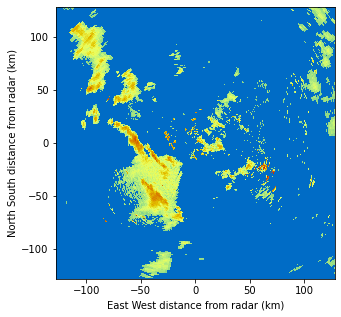

In [17]:
display = pyart.graph.RadarDisplay(radar)
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
display.plot('corrected_reflectivity',edges=True,sweep=0,vmin=0,mask_outside=True,colorbar_flag=False,title_flag=False)
display.set_limits(xlim=(-128, 128), ylim=(-128, 128))

## Display plot corrected_reflectivity, sweep=1

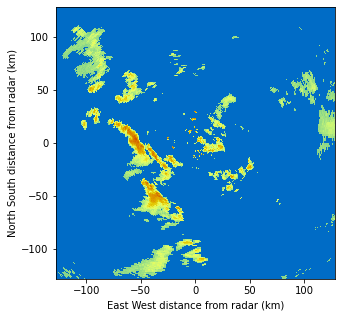

In [20]:
display = pyart.graph.RadarDisplay(radar)
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
display.plot('corrected_reflectivity',edges=True,sweep=1,vmin=0,mask_outside=True,colorbar_flag=False,title_flag=False)
display.set_limits(xlim=(-128, 128), ylim=(-128, 128))

## Mask some data using GateFilter.  Extract grid/Cartesian data from radar, then plot.

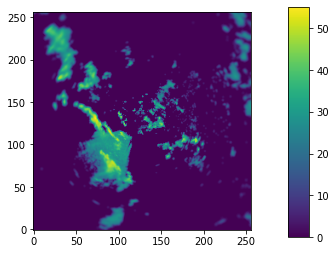

In [7]:
gatefilter = pyart.filters.GateFilter(radar)  #investigate this....
gatefilter.exclude_transition()
gatefilter.exclude_masked('corrected_reflectivity')

grid = pyart.map.grid_from_radars(radar,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8]) #investigate this, too....
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

# Start of Solutions

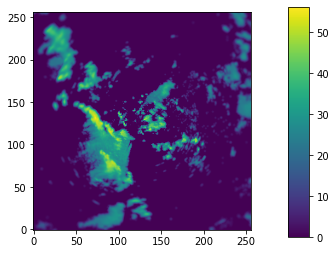

In [8]:
#element-wise maximum array
base = radar.extract_sweeps([0])
base_grid = pyart.map.grid_from_radars(base,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

#helper function
def transform_to_grid(alt):
    sweep = radar.extract_sweeps([0])
    sweep_data = radar.extract_sweeps([alt]).fields['corrected_reflectivity']['data']
    sweep_azi = radar.extract_sweeps([alt]).azimuth['data']
    sweep.fields['corrected_reflectivity']['data'] = sweep_data
    sweep.azimuth['data'] = sweep_azi

    grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])
    
    return grid.fields['corrected_reflectivity']['data']

#extract sweeps
max_arr = np.zeros((256,256))

#radar.nsweeps
for i in range(radar.nsweeps):
    sweep = transform_to_grid(i)
    max_arr = np.maximum(max_arr,sweep)  #numpy.maximum compares two arrays and returns the new array containing element-wise maxima.

base_grid.fields['corrected_reflectivity']['data'] = max_arr

fig, ax = plt.subplots()
im = ax.imshow(base_grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

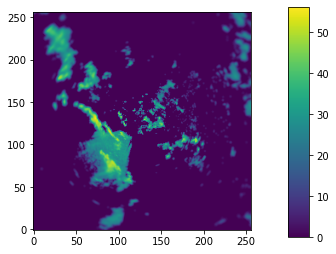

In [9]:
#Sample for sweep0
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([0]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([0]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

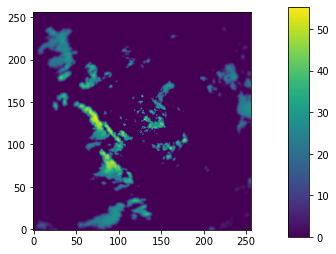

In [10]:
#Sample for sweep1
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([1]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([1]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

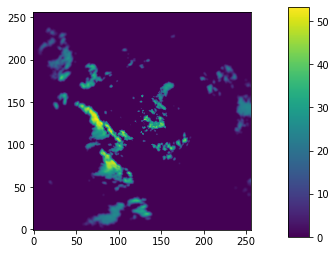

In [11]:
#Sample for sweep2
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([2]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([2]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

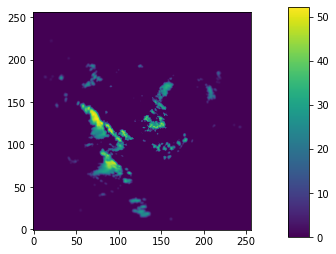

In [12]:
#Sample for sweep3
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([3]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([3]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

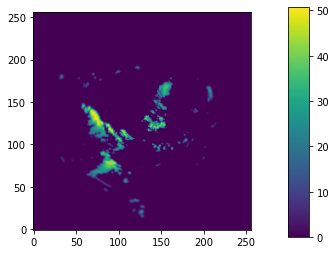

In [13]:
#Sample for sweep4
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([4]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([4]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

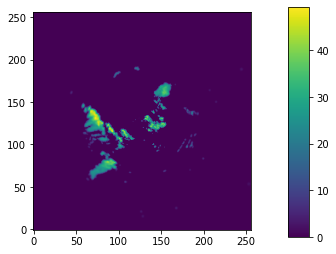

In [14]:
#Sample for sweep5
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([5]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([5]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

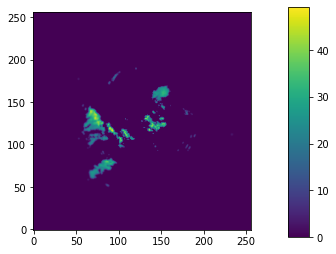

In [15]:
#Sample for sweep6
sweep = radar.extract_sweeps([0])
sweep_data = radar.extract_sweeps([6]).fields['corrected_reflectivity']['data']
sweep_azi = radar.extract_sweeps([6]).azimuth['data']
sweep.fields['corrected_reflectivity']['data'] = sweep_data
sweep.azimuth['data'] = sweep_azi

grid = pyart.map.grid_from_radars(sweep,grid_shape=(1,256,256),grid_limits=((0,2000),(-128000,128000),(-128000,128000)),fields=['corrected_reflectivity'])

fig, ax = plt.subplots()
im = ax.imshow(grid.fields['corrected_reflectivity']['data'][0],origin='lower')
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()